In [115]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [124]:
train_data = pd.read_csv("data/hate_speech_large.csv", names=['comments', 'label'], header=0)
test_data = pd.read_csv("data/dev.hate.csv")

In [125]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 190000


In [126]:
train_data.head() # 상위 5개 출력

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [127]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 471


In [128]:
test_data.head() # 상위 5개 출력

,comments,label
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,none
1,지현우 나쁜놈,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,hate
3,설마 ㅈ 현정 작가 아니지??,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,offensive


In [177]:
train_data.head(20)

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,@착한아이임당 A4 용지 덮고?,1
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",0
5,조원진이 비례대표나 경북에서 공천 못받고도 입다물면 친중질히던거 이해할게,1
6,후!!!!!!!!!!! 쩔었다...,0
7,오랜만에 휴가내서 조카들 데리고 보고나왔어요 !! 조카들이 너무 좋아해서 평점 10...,0
8,제목만 보고도 더러운 머리스탈 떠올랐다 이름보다 아 그더런새끼겠지? 이랬다니까,1
9,중국 공산당 보는것 같다,1


## 데이터 정제

In [129]:
train_data['label'] = np.where(train_data['label'] == 0, 1, 0)
test_data['label'] = np.where(test_data['label'] == 'none', 0, 1)
# train_data['label'] = train_data['label'].astype('float')
# test_data['label'] = test_data['label'].astype('float')

### 댓글의 중복 여부 확인

In [132]:
train_data['comments'].nunique(), train_data['label'].nunique()

(187142, 2)

In [133]:
train_data.drop_duplicates(subset=['comments'], inplace=True) # 중복 코멘트 제거
train_data.shape

(187143, 2)

In [134]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 187143


#### 레이블 값의 분포

<AxesSubplot:>

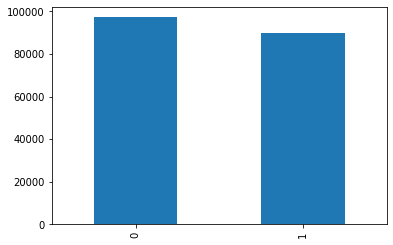

In [135]:
train_data['label'].value_counts().plot(kind = 'bar')

In [136]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [137]:
print(train_data.isnull().values.any())

True


In [138]:
print(train_data.isnull().sum())

comments    1
label       0
dtype: int64


In [139]:
train_data.loc[train_data.comments.isnull()]

,comments,label
7807,NaN,0


In [140]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [141]:
print(len(train_data))

187142


### 한글, 공백 제외 전처리

In [104]:
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0.0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0.0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1.0
3,착한아이임당 용지 덮고,1.0
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0.0


In [105]:
train_data['comments'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

comments    473
label         0
dtype: int64


In [106]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().sum())

comments    0
label       0
dtype: int64


In [107]:
print(len(train_data))

186669


In [142]:
test_data.drop_duplicates(subset = ['comments'], inplace=True) # 중복 코멘트 제거
test_data['comments'] = test_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['comments'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 471


## 토큰화

In [143]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [147]:
okt = Okt()
X_train = []
for sentence in train_data['comments']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [148]:
print(X_train[0])

['정말', '재밌다', '연기', '좋다', '디카프리오', '짱']


In [149]:
X_test = []
for sentence in test_data['comments']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [150]:
print(X_test[0])

['송중기', '시대극', '믿다', '보다', '첫', '회', '신선하다', '좋다']


## 정수 인코딩

In [151]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [152]:
print(len(tokenizer.word_index))

74345


In [156]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 74345
등장 빈도가 2번 이하인 희귀 단어의 수: 43622
단어 집합에서 희귀 단어의 비율: 58.675095836976254
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0410421506164034


In [157]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 30725


In [158]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [159]:
print(X_train[:3])

[[29, 25, 63, 16, 3486, 150], [25642, 247, 14393, 1357, 2197, 3171, 242, 1103, 10156, 242], [362, 14, 339, 485, 59, 77, 761, 110, 18]]


In [160]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [163]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

9

In [164]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

187133
187133


## 패딩

리뷰의 최대 길이 : 468
리뷰의 평균 길이 : 13.8600620948737


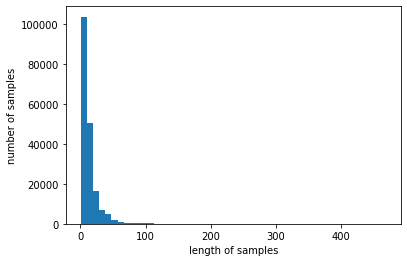

In [165]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [167]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [168]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 96.68684839125115


In [169]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM으로 악성 댓글 분류

In [170]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [171]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [172]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [173]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2495/2496 [============================>.] - ETA: 0s - loss: 0.1500 - acc: 0.9388
Epoch 00001: val_acc improved from -inf to 0.95180, saving model to best_model.h5
2496/2496 [==============================] - 150s 60ms/step - loss: 0.1500 - acc: 0.9388 - val_loss: 0.1202 - val_acc: 0.9518
Epoch 2/15
2495/2496 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9537
Epoch 00002: val_acc improved from 0.95180 to 0.95493, saving model to best_model.h5
2496/2496 [==============================] - 160s 64ms/step - loss: 0.1158 - acc: 0.9537 - val_loss: 0.1146 - val_acc: 0.9549
Epoch 3/15
2495/2496 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9591
Epoch 00003: val_acc improved from 0.95493 to 0.95789, saving model to best_model.h5
2496/2496 [==============================] - 155s 62ms/step - loss: 0.1040 - acc: 0.9591 - val_loss: 0.1063 - val_acc: 0.9579
Epoch 4/15
2495/2496 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.963

In [174]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

15/15 [==============================] - 0s 8ms/step - loss: 0.8829 - acc: 0.7113

 테스트 정확도: 0.7113


In [188]:
def sentiment_predict(new_sentence):
    sent = new_sentence
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{}: {:.2f}% --.\n".format(sent, score * 100))
    else:
        print("{}: {:.2f}% ++.\n".format(sent, (1 - score) * 100))

In [189]:
for sentence in test_data['comments']:
    sentiment_predict(sentence)

송중기 시대극은 믿고본다 첫회 신선하고 좋았다: 99.95% ++.

지현우 나쁜놈: 65.12% ++.

알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라: 97.08% --.

설마 ㅈ 현정 작가 아니지: 98.44% --.

이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀 하고사시죠: 71.16% --.

일베충들 ㅂㄷ거리는것봐라 ㅉㅉ: 97.93% --.

아이즈원 힘내세요일본 진출도 했으니 일본서 좋은 모습 보여줘도 팬들은 응원 합니다: 99.49% ++.

강부자 선생님 전미선 비보에 오열을 하셨다니 눈물이 나네요 힘내세요: 90.65% ++.

알았어 그만: 93.15% --.

이영자씨는 진정성 있는거라면 녹화불참으로 끝내지말고 자진하차해라 시청자는 고려도 안하고 일방적 불참은 아닌듯 엠비씨도 시청율 좋아서 고민하는거 같은데 결방할게 아니고 폐지해라: 60.44% --.

이경규가 이런거보면 세련되긴함 저 나이에 차은우 누가 알꼬 아무리 잘생겼다해도 배워야할점 많으신분: 86.69% --.

아발 어쩌라고 뭔기사가계속나오냐: 98.43% --.

진짜 멋지네요: 67.80% ++.

명수 응근슬쩍 뒷치기각잡네: 98.20% --.

철구한테 별풍쏜놈 수준도 똑같지 뭐 ㅋㅋ: 99.40% --.

둘이 화장실가서 싸우길: 50.11% ++.

송이매니저 거지냐 치과치료비용까지 남한테 타서 하게 솔직히 치아관리를 얼마나 안했으면 앞니가 시커멓게 될따까지 냅두냐 치과공포증은 핑계지 볼때마다 얼마나 거슬리는데 쟤네 부모님은 뭐하나 앞니하나 치료도 못해주고: 99.87% --.

언제까지 반일 감정에 불탈래 막상 역사도 그렇게 모르는 개돼지들이 꼭 흥분하더라: 99.58% --.

기자왜이래 이건 아니야 니 일기장에 써라 제목부터 오바야: 93.27% --.

이거 아직도 하: 84.20% --.

조우종이가 장성규보단 낫지장성규 얼마못간다: 97.52% --.

주말드라마에 장사하는엄마가 폐